# Introduction
In many simulation games, there is an element of trade. Typically, the player visits
various producers, which sells a certain set of good for a low price, and then delivers the
goods to various consumers, which would purchase the goods for a higher price. A natural
in these cases would be to maximize the profit after a successful run. For this analysis, the
focus is on Star Citizen, which is a space sim game currently in development. In SC, each outposts on planets/moons, and space stations has a list of goods that they would sell
and purchase. For instance, a mining outposts would sell various minerals while buying things like
medical supplies. Often, the producing location would sell the goods at a cheaper price. Thus, a
trading strategy would be to purchase goods from the producing locations to sell in major hubs like
space stations or cities. Thus, the goal would be to determine the optimal producers/consumers to
visit, and the amount to purchase/sell.

# Motivation
Currently, there are existing tools which can be used to find trade routes. However, these tools
are usually unable to find routes that span over multiple locations while carrying multiple types
of cargo. Furthermore, given the current state of supply in the game, the existing tools are also
unable to account for the expected low supply on highly profitable goods. Thus, by explicitly modeling
the problem in the language of optimization, some of these issues may be addressed.

# Problem Description
Since SC is a space sim, there are no "roads" that has to be considered. Each buyer/seller
can be directly reached from every other buyer/seller via quantum jump. The stopping points during
quantum jumps are empty space, and are meant to get around obstacles. In general, quantum
jumping within a planetary system does not take much time. However, quantum jumping between planets,
and to Lagrange points takes a longer period of time. At each stop, there are a set
of commodities that can be bought and sold at a price. Furthermore, there's a limited demand and
supply for each commodities, as well as a limit in the amount of available cargo space. Since
 there's a limited supply/demand, it would not be feasible to visit the same location multiple times
 on single trade run. Thus, each location should be visited at most once. Additionally, it is not
 necessary that the player starts and stop at the same location, but it can be a
desirable feature. Finally, it is also not necessary that the player starts from a specific location.
This implies that the trade route problem here is a variation of the TSP problem with selective locations, and
trade operations. Thus, the problem is NP-hard, but it can be formulated as a mixed integer programming problem
under the decision theory framework. In this case, the time step is introduced to order the trade operations and
remove subtours.

# Time Based Problem Formulation

First, the loss function $L(d(O), \theta)$ needs to be set. Let

$\theta = (B_{ilt}, S_{ilt}, D_{ilt}, P_{ilt})$, the modeled state of the world with

$B_{ilt}$ = the price to purchase commodity $i$ at location $l$ during step $t$

$S_{ilt}$ = the price to sell commodity $i$ at location $l$ during step $t$

$D_{ilt}$ = the demand for commodity $i$ at location $l$ during step $t$

$P_{ilt}$ = the supply for commodity $i$ at location $l$ during step $t$

Additionally, we can take that there are $N$ commodities, $C$ cargo space, $M$ locations, and a maximum of
$T$ steps to consider. Furthermore, we can set aside a virtual start location 0 to account for
arbitrary start location.

The route picked can be formulated as

$d(O) = d = (X_{ijt}, L_{ilt}, I_{ilt})$, with

$X_{ijt}$ = a binary variable indicating that the player goes from location i to location j at
time t

$L_{ilt}$ = the intended amount of good $i$ to sell at location $l$ at time $t$

$I_{ilt}$ = the intended amount of good $i$ to buy at location $l$ at time $t$

It is important to note that the only valid routes are the ones where the player is at a single
location at any given time. Furthermore, the player only buys and purchases goods at the current
location. Finally, since it takes a while for the commodities to refresh, the player is only allowed
to visit a location once per run.

Then, the trade loss function can be defined as

$L(d, \theta) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} min(P_{ilt}, I_{ilt})B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} min(D_{ilt}, L_{ilt})S_{ilt}$

Intuitively, it is the sum of money spent on actual purchases minus the sum of money made from
actual sells.

## Ideal Loss

Now, in an ideal situation, if we have an oracle, we can assume perfect information. Thus, let $O = \theta$, and the
decision rule chooses to purchase and sell within the observed supply/demand. This implies that $P_{ilt} >= I_{ilt}$ and $D_{ilt} >= L_{ilt}$, which
leads to

$L(d, \theta) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} I_{ilt}B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} L_{ilt}S_{ilt}$

Since $X = O$,
$R(d(O), \theta) = L(r, \theta)$, and the Bayes risk $r(d(O)) = E_{\theta}[R(d(O), \theta)]$

In the current state of the game, the price does not really change much, and only the supply/demand
fluctuates due to player actions, so

$E_{\theta}[R(d(O), \theta)] = R(d(O), \theta) = L(d, \theta)$, with the decision rule limiting
the purchases/sales with perfect foresight on supply and demand information. Then, minimizing
the bayes risk is essentially maximizing the profit, which will be realized with perfect information.

## Realistic Loss

In practice, the planner in fact cannot observe any information about the current state of the game.
Thus, let O = $\emptyset$, and consider each route r with the original loss function:

$L(r, \theta) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} min(P_{ilt}, I_{ilt})B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} min(D_{ilt}, L_{ilt})S_{ilt}$

taking expectations as before, the bayes risk becomes:

$r(d) = \sum\limits_{t} \sum\limits_{l} \sum\limits_{i} E_\theta[min(P_{ilt}, I_{ilt})]B_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} E_\theta[min(D_{ilt}, L_{ilt})]S_{ilt}$

Since the minimum has only 2 terms,

$E_\theta[min(P_{ilt}, I_{ilt})] = E_\theta E[min(P_{ilt}, I_{ilt}) | I(P_{ilt} <= I_{ilt})]$
$=E_\theta[I_{ilt} | P_{ilt} > I_{ilt}]Pr(P_{ilt} > I_{ilt}) + P_{ilt}Pr(P_{ilt} <= I_{ilt})$

A similar expression applies to $E_\theta[min(D_{ilt}, L_{ilt})]$.

The inclusion of probabilities based on $I$ and $L$ poses an issue, because the CDF of the
distributions for $P$ and $D$ is probably not even going to be convex. Thus, in order for the problem
to be efficiently solved, the loss has to be made linear or quadratic.

### Pessimistic Loss

The objective function can be made linear if the profit is a constraint instead. We can consider
only $d$ such that a K amount of profit is made. Then, to ensure that the route stays within
available supply and demand, the loss function can be setup to minimize the amount of goods purchased and sold.

$L(r, \theta) = ||I||_\infty + ||L||_\infty$

After minimizing the amount of goods bought and sold, we can hope (and assume)
that we had not exceeded the supply and demand. Then, the profit can be calculated as a linear function similar to
the ideal condition.

(PL) $\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} L_{ilt}S_{ilt} -
\sum\limits_{t} \sum\limits_{l} \sum\limits_{i} I_{ilt}B_{ilt} >= K$

#### Extension of the Pessimistic Loss

Under the previous formulation, all commodities are treated equally. However, this can lead to a worse upper
bound on $\epsilon$. For instance, suppose that there are two commodities A and B such that A generates more
profit than B. But, both generate enough profit to satisfy the profit constraint $K > 0$ if a full load of either good is
traded. In the case $T = 2, M = 2$, Let $X$ be the amount of A bought and sold, and $Y$ be the amount of B.
Then, the optimal solution would have $X \ge Y$. Suppose that $X < Y$, then we can swap the values of $X$ and $Y$, then decrease
$X$ to get a lower max while making the same amount of profit. Now, suppose that B is always available to buy and sell
in amount exceeding the cargo size, but the supply of A is at 0 for 99% of the time. Then, for all $\delta$,
trading only B fulfills $Pr(L'(d, \theta) - L(d, \theta) > \delta) < \epsilon$ for all $\epsilon$.
But, such route would never be generated since it would imply that $X = Y = 0$. This issue can be alleviated
if a weight is assigned to the buy and sell amount of each commodity, leading to the new loss function

$L(r, \theta) = ||W_b \cdot I||_\infty + ||W_s \cdot L||_\infty$

where $W_b$ are the buy weights, $W_s$ are the sell weights, and $\cdot$ indicates term by term multiplication.
By assigning the weight according to the scarcity of the supply/demand, some distributional information
can be captured by the pessimistic approach. For the previous example, the pure B route would be generated if
the weight for B is set to 0 for both buy and sell, while the weight of A can be set to 1. In addition, a
simple weighting scheme would be to simply set the weights as the inverse of supply and demand for non-zero
entries, and zero otherwise. This would normalize the amount bought and sold as percent of supply and demand.

### Approximating Ideal Condition

With perfect information, the original loss function involving min can be reduced to a linear
function. With imperfect foresight, the actual profit may differ from the ideal profit. The difference
and uncertainty can be quantified.

Let $L(d, \theta)$ be the ideal linear loss, and $L'(d, \theta)$ be the actual loss for a route d, we can
insist on picking route such that

$Pr(L'(d, \theta) - L(d, \theta) > \delta) < \epsilon$ for some $\epsilon$ and $\delta$.

Since the min limits the number of goods bought and sold, $L'(d, \theta) >= L(d, \theta)$ so the
quantity in the probability is always positive. By examining $L$ and $L'$, the value of $L'(d, \theta) - L(d, \theta)$
comes down to $I_{ilt} - min(P_{ilt}, I_{ilt})$ and $L_{ilt} - min(D_{ilt}, L_{ilt})$

Thus, this restriction can be implemented by limiting the maximum value on $I$ and $L$. The exact
strategy is another optimization problem, and likely would depend on the distribution of the supply
and demand. Since there are no available information on the distribution of the supply/demand,
this workaround is not considered in later analysis. However, by applying the
restriction to the routes, the linear profit loss function can be used knowing that the deviation in real
trading falls within acceptable limits.

## Constraints
The constraints on what is considered to be a route can be formulated linearly. Since the focus
is on the pessimistic loss, $D$ and $P$ are taken to be the maximum supply/demand. The specific
distribution of $D$ and $P$ only matters when trying to quantify the difference between theoretical
and realistic loss.

### Path

(1) $\forall i, t>=1, \sum\limits_j X_{ijt} <= min(1, \sum\limits_j X_{ji(t-1)})$

(2) $\forall t, \sum\limits_i \sum\limits_j X_{ijt} <= 1$

(3) $\forall j, \sum\limits_i \sum\limits_t X_{ijt} <= 1$

(4) $\sum\limits_j X_{0j0} = 1$

These constraints ensure that the path selected make sense in terms of traveling:

Constraint (1) ensures that a path from i to j can be made only when the player arrives at i at the previous
step.

Constraint (2) ensures that the the player travels only one path at each step.

Constraint (3) ensures that the player arrives at each location at most once.

Constraint (4) ensures that the player starts from "start".



### Buying/Selling Locations

(5) $\forall t, j, 3C\sum\limits_i X_{ijt} >= \sum\limits_g I_{gjt} + \sum\limits_g L_{gjt}$

(6) $\forall t, j, \sum\limits_g I_{gjt} + \sum\limits_g L_{gjt} >= \sum\limits_i Xijt$

These constraints ensure that the player only
buys and sells at their current location:

Constraints (5) makes it so that buying/selling any goods at location $j$ during time $t$
pushes up $\sum\limits_i X_{ijt}$ to 1, which implies that the player arrived at location $j$
before doing anything at $j$.

Constraints (6) ensures that if the player goes to a certain location, something was done there.

### Buying/Selling Amount

(7) $\forall t, \sum\limits_{n=0}^t \sum\limits_i \sum\limits_g I_{gin} - \sum\limits_{n=0}^t \sum\limits_i \sum\limits_g L_{gin} <= C$

(8) $\sum\limits_{g,i}L_{gi0} <= 0, \forall g, t >= 1, \sum\limits_i L_{git} <= \sum\limits_{n=0}^t \sum\limits_i I_{gin} - \sum\limits_{n=0}^{t-1} \sum\limits_i L_{gin}$

(9) $\sum\limits_{t,g,i} I_{git} = \sum\limits_{t,g,i} L_{git}$

(10) $\forall g, i, t, L_{git} >= 0, I_{git} >= 0$

(11) $\forall g, i, t, I_{git} <= P_{git}, L_{git} <= D_{git}$

These constraints ensure that the amount bought and sold are legitimate. In particular,

(7) ensures that all purchases does not exceed the maximum cargo amount

(8) ensures that the commodities sold are currently in possession.

(9) ensures that all goods bought will eventually be sold

(10) ensures that it is impossible to purchase and sell less than 0 unit of cargo.

(11) ensures that the decision rule picks out only the actions that are within max supply/demand

## Simplifications

Although the formulation supports different maximum supply/demand at the same location during different
steps, it is unlikely that the game would have that degree of variation. Thus, it can be assumed that the
maximum supply/demand stays the same across all time steps.

# Solving

The pessimistic formulation is implemented in Python using cvxpy. All of the constraints are linear in form, and
there exists a linear formulation of the objective function. Thus, the problem falls under MIP.

## Preparing Data

The supply, demand, and price information is extracted from SC Trade Tool. Then, the information
was organized in the matrix format as specified in the problem formulation. Then, only the locations
and commodities from ArcCorp is extracted. Thus, for this example, only intra-planetary trading
within ArcCorp is considered.

First, the shops info are read from a json file generated by the scraper

In [51]:
import math

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import json
import multiprocessing as mp
import pandas as pd
from sctrade_scraper import Shop
from sctrade_scraper import Commodity
from itertools import zip_longest
from itertools import product
import math

shops = []
shop_blk = []
with open("shops.json", "r") as fp:
    temp = json.load(fp)
    for t in temp:
        path = t[0]

        if "Stanton > Hurston" not in path and "start" != path:
            continue
        if path in shop_blk:
            continue

        buy_temp = t[1]
        sell_temp = t[2]
        buys = [Commodity(*b) for b in buy_temp]
        sells = [Commodity(*s) for s in sell_temp]

        shops.append(Shop(path, buys, sells))

shops.insert(0, Shop("start", [], []))
print("Number of Shops: " + str(len(shops)))

Number of Shops: 20


Next, the shops are converted to matrix form, which can be consumed by the solver.

In [2]:
from collections import namedtuple


class RoutePlanner:

    def __init__(self, shops):
        self.shops_idx = {s.path: i for i, s in enumerate(shops)}
        self.shops_rev_idx = {i: s.path for i, s in enumerate(shops)}
        self.commodities_idx = {}

        commodity_count = 0
        for s in shops:
            for b in s.buys:
                if b.name not in self.commodities_idx:
                    self.commodities_idx[b.name] = commodity_count
                    commodity_count = commodity_count + 1
            for sl in s.sells:
                if sl.name not in self.commodities_idx:
                    self.commodities_idx[sl.name] = commodity_count
                    commodity_count = commodity_count + 1

        self.commodities_rev_idx = {i: v for v, i in self.commodities_idx.items()}

        self.supply = np.zeros((len(self.commodities_idx), len(self.shops_idx)))
        self.demand = np.zeros((len(self.commodities_idx), len(self.shops_idx)))
        self.buy_price = np.zeros((len(self.commodities_idx), len(self.shops_idx)))
        self.sell_price = np.zeros((len(self.commodities_idx), len(self.shops_idx)))

        for s in shops:
            if s.path not in self.shops_idx:
                continue
            for b in s.buys:
                self.demand[self.commodities_idx[b.name], self.shops_idx[s.path]] = b.stock
                self.sell_price[self.commodities_idx[b.name], self.shops_idx[s.path]] = b.price
            for sl in s.sells:
                self.supply[self.commodities_idx[sl.name], self.shops_idx[s.path]] = sl.stock
                self.buy_price[self.commodities_idx[sl.name], self.shops_idx[s.path]] = sl.price

    def update_supply(self, good, location, amount):
        if good not in self.commodities_idx:
            raise KeyError("%s not found" % good)
        if location not in self.shops_idx:
            raise KeyError("%s not found" % location)
        if amount < 0:
            raise ValueError("amount cannot be negative")
        good_idx = self.commodities_idx[good]
        location_idx = self.shops_idx[location]
        self.supply[good_idx, location_idx] = amount

    def update_demand(self, good, location, amount):
        if good not in self.commodities_idx:
            raise KeyError("%s not found" % good)
        if location not in self.shops_idx:
            raise KeyError("%s not found" % location)
        if amount < 0:
            raise ValueError("amount cannot be negative")
        good_idx = self.commodities_idx[good]
        location_idx = self.shops_idx[location]
        self.demand[good_idx, location_idx] = amount


RoutePath = namedtuple("RoutePath", ["start", "end", "buy", "sell"])
Transaction = namedtuple("Transaction", ["loc_idx", "com_idx", "amount"])

## Coding the Problem

The pessimistic formulation is realized via cvxpy. Here, it is assumed that a C2 is used for
the trade run. The route is limited to a maximum of 4 stops.

In [62]:
TimeParameters = namedtuple("TimeParameters", ['C', 'K', 'X', 'I', 'L', 'Wb', 'Ws'])


class TimeBasedPlanner(RoutePlanner):

    def __init__(self, shops, solver = None, steps = 2):
        RoutePlanner.__init__(self, shops)
        self._prev_T = -1
        self._prob = None
        self._params = None
        self.solver = solver
        self.steps = steps

    def find_route(self, cargo, min_profit, steps = None):
        if steps is None:
            steps = self.steps
        buy_weight, sell_weight = self._create_weights()
        if steps != self._prev_T:
            self._prob, self._params =  self._formulate_problem(steps + 1)
            self._prev_T = steps
            self._params.Wb.value = buy_weight
            self._params.Ws.value = sell_weight
        self._params.C.value = cargo
        self._params.K.value = min_profit
        obj = self._prob.solve(solver = self.solver)
        routes = self._extract_routes(steps + 1, self._params.X, self._params.I, self._params.L)
        return obj, routes

    def _extract_transactions(self, array):
        non_zero = np.nonzero(array.value)
        items = []
        for i, idx in enumerate(non_zero[0]):
            col_idx = non_zero[1][i]
            amount = array[idx, col_idx].value
            commodity = self.commodities_rev_idx[idx]
            location = self.shops_rev_idx[col_idx]
            items.append(Transaction(location, commodity, amount))
        return items

    def _extract_routes(self, steps, path_mat, buy_mat, sell_mat):
        paths = []
        for t in range(steps):
            non_zero = np.nonzero(path_mat[t].value)
            if len(non_zero[0]) == 0:
                break
            start_idx = non_zero[0][0]
            end_idx = non_zero[1][0]
            start_loc = self.shops_rev_idx[start_idx]
            end_loc = self.shops_rev_idx[end_idx]
            buy = self._extract_transactions(buy_mat[t])
            sell = self._extract_transactions(sell_mat[t])
            paths.append(RoutePath(start_loc, end_loc, buy, sell))
        return paths

    def _create_weights(self):
        buy_weight = np.divide(1, self.supply, out = np.zeros_like(self.supply), where = self.supply != 0)
        sell_weight = np.divide(1, self.demand, out = np.zeros_like(self.demand), where = self.demand != 0)
        return buy_weight, sell_weight

    def _formulate_problem(self, T):
        C = cp.Parameter(nonneg=True)
        K = cp.Parameter(nonneg=True)
        M = len(self.shops_idx)
        N = len(self.commodities_idx)
        Wb = cp.Parameter((N, M), nonneg=True)
        Ws = cp.Parameter((N, M), nonneg=True)

        # Theta
        b = cp.Parameter((N, M), nonneg=True)
        s = cp.Parameter((N, M), nonneg=True)
        d = cp.Parameter((N, M), nonneg=True)
        p = cp.Parameter((N, M), nonneg=True)
        B = [b for _ in range(T)]
        S = [s for _ in range(T)]
        D = [d for _ in range(T)]
        P = [p for _ in range(T)]

        # r
        X = [cp.Variable((M, M), boolean=True) for _ in range(T)]
        L = [cp.Variable((N, M), nonneg=True) for _ in range(T)]
        I = [cp.Variable((N, M), nonneg=True) for _ in range(T)]


        # L(d(O), theta)
        objective = cp.Minimize(cp.maximum(cp.maximum(*[cp.max(cp.multiply(I[t], Wb)) for t in range(T)]),
                                cp.maximum(*[cp.max(cp.multiply(L[t], Ws)) for t in range(T)])))

        constraints = []

        # Path Constraints
        # (1)
        for i in range(M):
            for t in range(1, T):
                c = cp.sum(X[t][i]) <= cp.minimum(1, cp.sum(X[t - 1][:, i]))
                constraints.append(c)

        # (2)
        for t in range(T):
            constraints.append(cp.sum(X[t]) <= 1)

        # (3)
        for j in range(M):
            constraints.append(
                sum([cp.sum(X[t][:, j]) for t in range(T)]) <= 1
            )

        # (4)
        constraints.append(cp.sum(X[0][0]) == 1)

        # Buy/Sell Location Constraints
        # (5)
        for t in range(T):
            for j in range(M):
                constraints.append(3 * C * cp.sum(X[t][:, j]) >=
                                   cp.sum(I[t][:, j]) + cp.sum(L[t][:, j]))

        # (6)
        for t in range(T):
            for j in range(M):
                constraints.append(cp.sum(I[t][:, j]) + cp.sum(L[t][:, j]) >=
                                   cp.sum(X[t][:, j]))

        # Buy/Sell Amount Constraints
        # (7)
        for t in range(T):
            constraints.append(
                sum([cp.sum(I[n]) for n in range(t)]) -
                sum([cp.sum(L[n]) for n in range(t)]) <= C
            )

        # (8)
        for g in range(N):
            for t in range(1, T):
                constraints.append(
                    cp.sum(L[t][g]) <= sum([cp.sum(I[n][g]) for n in range(t + 1)]) -
                    sum([cp.sum(L[n][g]) for n in range(t)])
                )

        constraints.append(cp.sum(L[0]) <= 0)

        # (9)
        constraints.append(
            sum([cp.sum(L[t]) for t in range(T)]) ==
            sum([cp.sum(I[t]) for t in range(T)])
        )

        # (10), (11)
        for t in range(T):
            constraints.append(
                I[t] <= P[t]
            )
            constraints.append(
                L[t] <= D[t]
            )

        # (PL)
        constraints.append(sum([cp.sum(cp.multiply(L[i], S[i])) for i in range(T)]) -
                           sum([cp.sum(cp.multiply(I[i], B[i])) for i in range(T)]) >= K)

        prob = cp.Problem(objective, constraints)

        b.value = np.array(self.buy_price)
        s.value = np.array(self.sell_price)
        d.value = np.array(self.demand)
        p.value = np.array(self.supply)

        return prob, TimeParameters(C, K, X, I, L, Wb, Ws)


def print_plan(routes):
    for path in routes:
        if len(path.buy) == 0 and len(path.sell) == 0:
            continue
        print("---------------------------------------------")
        print("Start: " + path.start)
        print("End: " + path.end)
        print("Buy:")
        for item in path.buy:
            print("\t%f units of %s" % (item.amount, item.com_idx))
        print("Sell")
        for item in path.sell:
            print("\t%f units of %s" % (item.amount, item.com_idx))

## Solutions of the problem

A trade off curve of the objective function vs minimum profit is shown below. The relation betwen
minimum profit and the objective function is close to linear. However, as the minimum profit increases, the norm
increases at a faster rate. This is a sign that the solver is forced to
assign more units to a few lucrative commodities instead of spreading them out.

In [5]:
%%time
N_STEPS = 6

def generate_cargo_tradeoffs(steps):
    attempts = []
    norm = []
    time_planner = TimeBasedPlanner(shops)

    for i in range(0, 300001, 25000):
        opt, _ = time_planner.find_route(69600, i, steps = steps)
        if opt == np.nan:
            break
        attempts.append(i)
        norm.append(opt)

    return pd.DataFrame({"Min. Profit": attempts, "Norm": norm, "Step": [steps for _ in attempts]})


with mp.Pool(N_STEPS) as pool:
    results = pool.map(generate_cargo_tradeoffs, [i + 1 for i in range(N_STEPS)])

CPU times: user 8.37 s, sys: 3.28 s, total: 11.7 s
Wall time: 4h 13min 7s


It can be seen from the trade off plot that routes with one step almost require
getting at least around half of the cargo from some location as the required
profit goes toward 300k. However, up until around 125k, it is possible to stay
within 10% of the supply + demand even with 1 step. For high profit, routes with
4, 5, or 6 steps has a rather flat trade off curve throughout, and stay below
20% of supply + demand at maximum. For route with 2 or 3 steps, it seems that
the route with 2 steps experiences a larger increasing slope on the trade-off
chart as the profit increases. Suppose that the threshold is set at supply + demand
less than 20%, then a route with 3 steps would seem appropriate with the least
amount of travel.

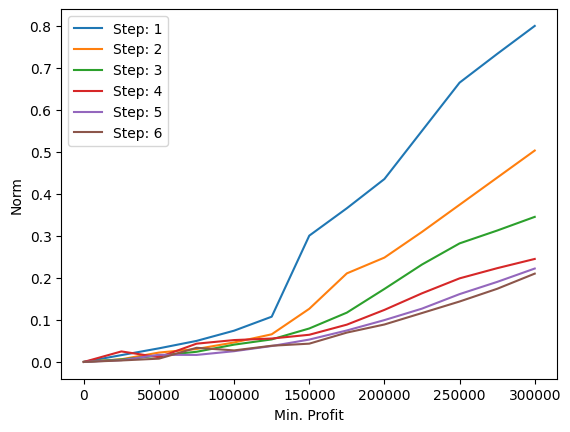

In [6]:
for f in results:
    plt.plot(f["Min. Profit"], f["Norm"], label = "Step: " + str(f["Step"][0]))

plt.legend()
plt.xlabel("Min. Profit")
plt.ylabel("Norm")
plt.show()

An optimal route with 200K minimum profit with 3 steps is calculated below.

In [7]:
%%time
time_planner = TimeBasedPlanner(shops)
opt, routes = time_planner.find_route(69600, 200000, steps = 3)
print_plan(routes)

---------------------------------------------
Start: start
End: Stanton > ArcCorp > Lyria > Shubin Mining Facility SAL-2
Buy:
	724.031008 units of Agricium
	68875.968992 units of Titanium
Sell
---------------------------------------------
Start: Stanton > ArcCorp > Lyria > Shubin Mining Facility SAL-2
End: Stanton > ArcCorp > Area18 > Trade and Development Division
Buy:
	14480.620155 units of Scrap
Sell
	724.031008 units of Agricium
	68875.968992 units of Titanium
---------------------------------------------
Start: Stanton > ArcCorp > Area18 > Trade and Development Division
End: Stanton > ArcCorp > Lyria > The Orphanage
Buy:
	724.031008 units of E'tam
	724.031008 units of Altruciatoxin
	724.031008 units of SLAM
Sell
---------------------------------------------
Start: Stanton > ArcCorp > Lyria > The Orphanage
End: Stanton > ArcCorp > Wala > Samson & Son's Salvage Center
Buy:
Sell
	14480.620155 units of Scrap
	724.031008 units of E'tam
	724.031008 units of Altruciatoxin
	724.031008 uni

# Two-Step Formulation

In [53]:
HighLevelPlan = namedtuple("HighLevelPlan", ['cost', 'revenue', 'buy', 'sell'])


def compute_travel_cost(paths, path_idx):
    result = np.zeros((len(paths), len(paths)))
    max_level = -1
    for p in paths:
        p_pars = p.split(">")
        if len(p_pars) >= max_level:
            max_level = len(p_pars)

    for shop_a, shop_b in product(paths, paths):
        ix_a, ix_b = path_idx[shop_a], path_idx[shop_b]
        if shop_a == shop_b:
            result[ix_a, ix_b] = 0
        parts_a = shop_a.split(">")
        parts_b = shop_b.split(">")
        curr_level = max_level
        for a, b in zip_longest(parts_a, parts_b, fillvalue="-1"):
            if a.strip() != b.strip():
                result[ix_a, ix_b] = curr_level
            curr_level = curr_level - 1
    return result


class HighLevelPlanner(RoutePlanner):

    def __init__(self, shops, levels = 5, solver = None):
        RoutePlanner.__init__(self, shops)
        self._create_weights()
        self.levels = levels
        self._formulate_step_one()
        self._trv_c = compute_travel_cost([s.path for s in shops], self.shops_idx)
        self.solver = solver

    def plan_stage_one(self, cargo, max_percent = 0.2, max_level = 2, n_stop = 3):
        self._B.value = np.array(self.buy_price)
        self._S.value = np.array(self.sell_price)
        self._D.value = np.array(self.demand)
        self._P.value = np.array(self.supply)
        self._R.value = self._trv_c
        self._C.value = cargo
        self._ML.value = max_level
        self._NS.value = n_stop
        self._Q.value = max_percent
        self._Wb.value = self._buy_weight
        self._Ws.value = self._sell_weight
        profit = self._prob_one.solve(solver=self.solver)
        if math.isfinite(profit):
            return profit, self._extract_stage_one()
        return profit, None

    def _extract_stage_one(self):
        buy_transactions = []
        sell_transactions = []

        for com, loc in zip(*np.nonzero(self._I.value)):
            buy_transactions.append(Transaction(self.shops_rev_idx[loc],
                                                self.commodities_rev_idx[com],
                                                self._I.value[com, loc]))
        for com, loc in zip(*np.nonzero(self._L.value)):
            sell_transactions.append(Transaction(self.shops_rev_idx[loc],
                                                self.commodities_rev_idx[com],
                                                self._L.value[com, loc]))
        revenue = np.sum(np.multiply(self._L.value, self._S.value))
        cost = np.sum(np.multiply(self._I.value, self._B.value))
        return HighLevelPlan(cost, revenue, buy_transactions, sell_transactions)

    def _create_weights(self):
        self._buy_weight = np.divide(1, self.supply, out = np.zeros_like(self.supply), where = self.supply != 0)
        self._sell_weight = np.divide(1, self.demand, out = np.zeros_like(self.demand), where = self.demand != 0)

    def _formulate_step_one(self):
        self._C = cp.Parameter(nonneg=True, name="C")
        self._ML = cp.Parameter(name = "ML")
        self._NS = cp.Parameter(name = "NS")
        self._M = len(self.shops_idx)
        self._N = len(self.commodities_idx)
        self._Q = cp.Parameter(nonneg=True, name="Q")
        self._Wb = cp.Parameter((self._N, self._M), nonneg=True, name="Wb")
        self._Ws = cp.Parameter((self._N, self._M), nonneg=True, name="Ws")

        self._B = cp.Parameter((self._N, self._M), nonneg=True, name="B")
        self._S = cp.Parameter((self._N, self._M), nonneg=True, name="S")
        self._D = cp.Parameter((self._N, self._M), nonneg=True, name="D")
        self._P = cp.Parameter((self._N, self._M), nonneg=True, name="P")
        self._R = cp.Parameter((self._M, self._M), nonneg=True, name="R")

        self._I = cp.Variable((self._N, self._M), nonneg=True)
        self._L = cp.Variable((self._N, self._M), nonneg=True)
        self._X = cp.Variable((self._M, self._M), boolean=True)

        objective = cp.Maximize(cp.sum(cp.multiply(self._L, self._S)) - cp.sum(cp.multiply(self._I, self._B)))

        constraints = []

        # (1)
        constraints.append(
            cp.sum(self._I, axis = 1) == cp.sum(self._L, axis = 1)
        )

        # (2)
        constraints.append(
            cp.sum(self._I, axis = 0) <= self._C
        )

        # (3)
        constraints.append(
            cp.sum(self._L, axis = 0) <= self._C
        )

        # (4)
        for i in range(self._M):
            for j in range(i, self._M):
                purchase_amount = (cp.sum(self._I[:, i]) + cp.sum(self._L[:, i]) +
                                   cp.sum(self._I[:, j]) + cp.sum(self._L[:, j]))
                constraints.append(
                    10 * self._C * self._X[i, j] >= purchase_amount
                )
                constraints.append(purchase_amount >= self._X[i, j])

        # (5)
        constraints.append(
            cp.maximum(cp.max(cp.multiply(self._L, self._Ws)), cp.max(cp.multiply(self._I, self._Wb))) <= self._Q
        )

        # (6)
        constraints.append(
            self._I <= self._P
        )

        # (7)
        constraints.append(
            self._L <= self._D
        )

        # (8)
        constraints.append(
            cp.max(cp.multiply(self._X, self._R)) <= self._ML
        )

        # (9)
        constraints.append(
            cp.sum(cp.diag(self._X)) == self._NS
        )

        self._prob_one = cp.Problem(objective, constraints)


def build_idx(transactions):
    locations = set()
    commodities = set()
    shop_idx = {}
    shop_rev_idx = {}
    com_idx = {}
    com_rev_idx = {}
    for t in transactions:
        locations.add(t.loc_idx)
        commodities.add(t.com_idx)
    for i, p in enumerate(locations):
        shop_idx[p] = i
        shop_rev_idx[i] = p
    for i, p in enumerate(commodities):
        com_idx[p] = i
        com_rev_idx[i] = p

    return shop_idx, shop_rev_idx, com_idx, com_rev_idx


class LowLevelRoutePlanner:

    def __init__(self, solver = None):
        self.solver = solver
        self._S = None
        self._D = None
        self._R = None
        self._C = None
        self._F = []
        self._X = None
        self._I = None
        self._L = None
        self._prev_com_size = -1
        self._prev_loc_size = -1
        self._prev_visits = -1

    def plan_route(self, max_cargo, max_visits, high_level_plan):
        shop_idx, shop_rev_idx, com_idx, com_rev_idx = build_idx([t for t in high_level_plan.buy] + [t for t in high_level_plan.sell])
        n_locs = len(shop_idx)
        n_coms = len(com_idx)
        if n_locs != self._prev_loc_size or \
           n_coms != self._prev_com_size or \
           max_visits != self._prev_visits:
            self._formulate_problem(max_visits, n_locs, n_coms)
            self._prev_com_size = n_coms
            self._prev_loc_size = n_locs
            self._prev_visits = max_visits

        self._S.value = np.zeros((n_coms, n_locs))
        self._D.value = np.zeros((n_coms, n_locs))
        self._R.value = compute_travel_cost([shop_rev_idx[i] for i in range(n_locs)], shop_idx)
        self._R.value = np.power(10, self._R.value)
        self._C.value = max_cargo
        for t in high_level_plan.buy:
            self._S.value[com_idx[t.com_idx], shop_idx[t.loc_idx]] = t.amount
        for t in high_level_plan.sell:
            self._D.value[com_idx[t.com_idx], shop_idx[t.loc_idx]] = t.amount
        cost = self._prob.solve(solver = self.solver)
        if math.isfinite(cost):
            return cost, self._extract_route(max_visits, shop_rev_idx, com_rev_idx)
        return cost, None

    def _extract_route(self, max_visits, rev_shop_idx, rev_com_idx):
        cur_idx = np.nonzero(self._X.value[-2, :])[0][0]
        final_routes = []

        cur_start = "start"
        while cur_idx != self._X.value.shape[0] - 1:
            shop_i = int(math.floor(cur_idx / max_visits))
            shop_name = rev_shop_idx[shop_i]
            cur_end = shop_name
            buy_transactions = []
            sell_transactions = []

            for com in np.nonzero(self._I.value[:, cur_idx])[0]:
                buy_transactions.append(Transaction(rev_shop_idx[shop_i],
                                                    rev_com_idx[com],
                                                    self._I.value[com, cur_idx]))
            for com in np.nonzero(self._L.value[:, cur_idx])[0]:
                sell_transactions.append(Transaction(rev_shop_idx[shop_i],
                                                    rev_com_idx[com],
                                                    self._L.value[com, cur_idx]))
            final_routes.append(RoutePath(cur_start, cur_end, buy_transactions, sell_transactions))
            cur_start = shop_name
            cur_idx = np.nonzero(self._X.value[cur_idx, :])[0][0]
        return final_routes

    def _formulate_problem(self, max_visit, n_locs, n_coms):
        self._S = cp.Parameter((n_coms, n_locs), nonneg=True)
        self._D = cp.Parameter((n_coms, n_locs), nonneg=True)
        self._R = cp.Parameter((n_locs, n_locs), nonneg=True)
        self._C = cp.Parameter(nonneg=True)

        self._MCF = [cp.Variable((n_locs * max_visit + 2, n_locs * max_visit + 2), nonneg=True) for _ in range(n_locs * max_visit + 2)]
        self._F = [cp.Variable((n_locs * max_visit, n_locs * max_visit), nonneg=True) for _ in range(n_coms)]
        self._X = cp.Variable((n_locs * max_visit + 2, n_locs * max_visit + 2), boolean=True)
        self._I = cp.Variable((n_coms, n_locs * max_visit ), nonneg=True)
        self._L = cp.Variable((n_coms, n_locs * max_visit), nonneg=True)

        expanded_cost = 0
        for i in range(n_locs):
            for j in range(n_locs):
                i_start = i * max_visit
                i_end = i_start + max_visit
                j_start = j * max_visit
                j_end = j_start + max_visit
                expanded_cost = expanded_cost + cp.sum(self._X[i_start:i_end, j_start:j_end]) * self._R[i, j]

        objective = cp.Minimize(expanded_cost)

        constraints = []

        # (1)
        constraints.append(
            cp.sum(self._X[:-1, :], axis=1) == 1
        )

        # (2)
        constraints.append(
            cp.sum(self._X[:, :-2], axis = 0) == 1
        )

        constraints.append(cp.sum(self._X[:, -1]) == 1)
        constraints.append(cp.sum(self._X[-1, :]) == 0)
        constraints.append(cp.sum(self._X[-2, :]) == 1)
        constraints.append(cp.sum(self._X[:, -2]) == 0)

        k_range = list(range(0, n_locs * max_visit + 2))
        k_range.remove(n_locs * max_visit)
        for flow in self._MCF:
            constraints.append(self._X >= flow)

        for k in k_range:
            constraints.append(
                cp.sum(self._MCF[k][(n_locs * max_visit), :]) == 1
            )

        for k in k_range:
            constraints.append(
                cp.sum(self._MCF[k][:, k]) == 1
            )

        for k in k_range:
            j_range = list(range(0, n_locs * max_visit))
            j_range.append(n_locs * max_visit + 1)
            j_range.remove(k)
            for j in j_range:
                constraints.append(
                    cp.sum(self._MCF[k][:, j]) ==
                    cp.sum(self._MCF[k][j, :]) - self._MCF[k][j, n_locs * max_visit]
                )

        # (3)
        for flow in self._F:
            constraints.append(10 * self._C * self._X[:-2, :-2] >= flow)

        # (4)
        for g, flow in enumerate(self._F):
            for j in range(n_locs * max_visit):
                constraints.append(
                    cp.sum(flow[j, :]) - cp.sum(flow[:, j]) == self._I[g, j] - self._L[g, j]
                )

        # (5) (6)
        for g in range(n_coms):
            for i in range(n_locs):
                start = i * max_visit
                end = start + max_visit
                constraints.append(cp.sum(self._I[g, start:end]) == self._S[g, i])
                constraints.append(cp.sum(self._L[g, start:end]) == self._D[g, i])

        # (7)
        agg_flow = sum(self._F)
        constraints.append(
            cp.sum(agg_flow, axis = 1) <= self._C
        )

        self._prob = cp.Problem(objective, constraints)


ts_planner = HighLevelPlanner(shops, solver="CPLEX")

In [60]:
def print_high_level_plan(plan):
    if plan is None:
        print("Infeasible/No Solution")
        return

    buy_consolidate = {}
    sell_consolidate = {}

    for t in plan.buy:
        if t.loc_idx not in buy_consolidate:
            buy_consolidate[t.loc_idx] = [t]
        else:
            buy_consolidate[t.loc_idx].append(t)

    for t in plan.sell:
        if t.loc_idx not in sell_consolidate:
            sell_consolidate[t.loc_idx] = [t]
        else:
            sell_consolidate[t.loc_idx].append(t)

    print("Revenue: %f, Cost: %f, Profit: %f" % (plan.revenue, plan.cost, plan.revenue - plan.cost))
    print("----------------------Purchases----------------------")
    for loc, trans in buy_consolidate.items():
        print("At: %s" % loc)
        for t in trans:
            print("\tBuy: %f units of %s" % (t.amount, t.com_idx))
    print("----------------------Sell----------------------")
    for loc, trans in sell_consolidate.items():
        print("At: %s" % loc)
        for t in trans:
            print("\tSell: %f units of %s" % (t.amount, t.com_idx))


profit, plan = ts_planner.plan_stage_one(9600, n_stop=4, max_percent=0.1)
print_high_level_plan(plan)

Revenue: 350752.000000, Cost: 281756.000000, Profit: 68996.000000
----------------------Purchases----------------------
At: Stanton > Hurston > Arial > HDMS-Bezdek
	Buy: 4600.000000 units of Laranite
	Buy: 5000.000000 units of Titanium
At: Stanton > Hurston > Arial > HDMS-Lathan
	Buy: 5000.000000 units of Laranite
At: Stanton > Hurston > Lorville > Central Business District
	Buy: 4600.000000 units of Scrap
----------------------Sell----------------------
At: Stanton > Hurston > Lorville > Central Business District
	Sell: 9600.000000 units of Laranite
At: Stanton > Hurston > Reclamation & Disposal Orinth
	Sell: 5000.000000 units of Titanium
	Sell: 4600.000000 units of Scrap


In [63]:
ts_l_planner = LowLevelRoutePlanner(solver = "CPLEX")
cost, routes = ts_l_planner.plan_route(9600, 2, plan)
print_plan(routes)

---------------------------------------------
Start: start
End: Stanton > Hurston > Arial > HDMS-Lathan
Buy:
	5000.000000 units of Laranite
Sell
---------------------------------------------
Start: Stanton > Hurston > Arial > HDMS-Lathan
End: Stanton > Hurston > Arial > HDMS-Bezdek
Buy:
	4600.000000 units of Laranite
Sell
---------------------------------------------
Start: Stanton > Hurston > Arial > HDMS-Bezdek
End: Stanton > Hurston > Lorville > Central Business District
Buy:
Sell
	9600.000000 units of Laranite
---------------------------------------------
Start: Stanton > Hurston > Lorville > Central Business District
End: Stanton > Hurston > Lorville > Central Business District
Buy:
	4600.000000 units of Scrap
Sell
---------------------------------------------
Start: Stanton > Hurston > Lorville > Central Business District
End: Stanton > Hurston > Arial > HDMS-Bezdek
Buy:
	5000.000000 units of Titanium
Sell
---------------------------------------------
Start: Stanton > Hurston > A

# Discussion

Without gathering specific data on the supply and demand information, the pessimistic loss can
serve as a good starting point for a trade route that tries to limit the effect of shortages. With
sufficient data, using the more explicit formulation may result in more profit over time. After all,
the pessimistic formulation can be seen as an approximation of
$Pr(L'(d, \theta) - L(d, \theta) > \delta) < \epsilon$ where the routes considered are the ones that
exceeds the $K$ theoretical profits. In the trivial case where only one type of commodities is present,
minimizing the max is equivalent to minimizing the amount of goods purchased, and thus it minimizes
$\epsilon$ for all $\delta$. In more complicated situations, the minimized max still serves as an upperbound
on the goods, which leads to an upper bound on $\epsilon$. In fact, it seems probable that the optimal solution
under the pessimistic formulation minimizes $\epsilon$ for some $\delta$ under some non-trivial distribution of
supply/demand. In fact, if the L-infinity norm is changed to the L-2 norm, then it would be equivalent to placing
a normal prior on the possible state space where the supply and demand of each commodity are i.i.d. and
follows $N(0,\sigma^2)$ for some constant sigma.

From a parametrization perspective, although the time step based formulation is not the type of extended TSP
formulation that has the best LP-relaxation lower bound, or the most compact, it works in this problem because
of the need to track whether a good was purchased before sold. Thus, by introducing time, the order of the trade
operations can be taken into account.